In [308]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import yfinance as yf

from talib import abstract
# directly import sma
SMA = abstract.SMA
MACD = abstract.MACD
RSI = abstract.RSI

from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

## Getting Data from Yahoo Example
Additional info: https://pypi.org/project/yfinance/

In [313]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# S&P500 index: ^GSPC
stock = yf.Ticker("^GSPC")

# one way to get data for period of interest
df = stock.history(period="1y")
df

# Other potential fields of interest
# stock.info
# stock.major_holders
# stock.recommendations
# stock.options

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-02-13,3365.899902,3385.090088,3360.520020,3373.939941,3498240000,0,0
2020-02-14,3378.080078,3380.689941,3366.149902,3380.159912,3398040000,0,0
2020-02-18,3369.040039,3375.010010,3355.610107,3370.290039,3746720000,0,0
2020-02-19,3380.389893,3393.520020,3378.830078,3386.149902,3600150000,0,0
2020-02-20,3380.449951,3389.149902,3341.020020,3373.229980,4007320000,0,0
...,...,...,...,...,...,...,...
2021-02-08,3892.590088,3915.770020,3892.590088,3915.590088,4635030000,0,0
2021-02-09,3910.489990,3918.350098,3902.639893,3911.229980,4554610000,0,0
2021-02-10,3920.780029,3931.500000,3884.939941,3909.879883,4815380000,0,0


### Adding Return Data

In [314]:
# Daily return based on Close price
df["Return"] = df["Close"] - df["Close"].shift(1)
df["Return%"] = df["Return"] / df["Close"]

# Next 5 day return based on Close price
df["N5D_Return"] = (df["Close"] - df["Close"].shift(-5)) * -1
df["N5D_Return%"] = df["N5D_Return"] / df["Close"]

df.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,N5D_Return%
Date,,,,,,,,,,,
2020-02-13,3365.899902,3385.090088,3360.520020,3373.939941,3498240000,0,0,NaN,NaN,-36.189941,-0.010726
2020-02-14,3378.080078,3380.689941,3366.149902,3380.159912,3398040000,0,0,6.219971,0.001840,-154.270020,-0.045640
2020-02-18,3369.040039,3375.010010,3355.610107,3370.290039,3746720000,0,0,-9.869873,-0.002928,-242.080078,-0.071828
2020-02-19,3380.389893,3393.520020,3378.830078,3386.149902,3600150000,0,0,15.859863,0.004684,-269.760010,-0.079666
2020-02-20,3380.449951,3389.149902,3341.020020,3373.229980,4007320000,0,0,-12.919922,-0.003830,-394.469971,-0.116941
2020-02-21,3360.500000,3360.760010,3328.449951,3337.750000,3899270000,0,0,-35.479980,-0.010630,-383.530029,-0.114907
2020-02-24,3257.610107,3259.810059,3214.649902,3225.889893,4842960000,0,0,-111.860107,-0.034676,-135.659912,-0.042053
2020-02-25,3238.939941,3246.989990,3118.770020,3128.209961,5591510000,0,0,-97.679932,-0.031226,-124.839844,-0.039908
2020-02-26,3139.899902,3182.510010,3108.989990,3116.389893,5478110000,0,0,-11.820068,-0.003793,13.730225,0.004406


### Adding Trading Signals to the Data

In [331]:
# Add SMA Signal
sma_fast = SMA(df.Close, 3)
sma_slow = SMA(df.Close, 15)
sma_signal = pd.Series(sma_fast > sma_slow).astype(int).diff().fillna(0)
df["SMA_Signal"] = sma_signal.values

# Add MACD Signal
macd, macdsignal, macdhist = MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
macd_signal = pd.Series(macd > macdsignal).astype(int).diff().fillna(0)
df["MACD_Signal"] = macd_signal.values

# Add RSI Level and Signal
real = RSI(df.Close, timeperiod=14)
df["RSI"] = real
timeperiod = 14
overbought = 70
oversold = 30
buy_signal = pd.Series(real <= 30).astype(int)
sell_signal = pd.Series(real >= 70).astype(int) * -1
rsi_signal = buy_signal + sell_signal
df["RSI_Signal"] = rsi_signal.values

df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Return%,N5D_Return,N5D_Return%,SMA_Signal,MACD_Signal,RSI,RSI_Signal
count,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.0,253.0,252.000000,252.000000,248.000000,248.000000,253.000000,253.000000,239.000000,253.000000
mean,3278.585447,3303.922963,3249.987785,3278.613953,5.101271e+09,0.0,0.0,2.225755,0.000368,10.903791,0.003874,0.003953,0.003953,56.482618,-0.023715
std,372.819325,364.038499,383.835430,374.043755,1.330749e+09,0.0,0.0,61.888405,0.022220,123.101036,0.041391,0.227094,0.274556,10.699775,0.266203
min,2290.709961,2300.729980,2191.860107,2237.399902,1.885090e+09,0.0,0.0,-324.890137,-0.136158,-543.300049,-0.179666,-1.000000,-1.000000,23.017232,-1.000000
25%,3045.750000,3079.760010,2998.610107,3036.129883,4.184930e+09,0.0,0.0,-20.265015,-0.006389,-32.600098,-0.010284,0.000000,0.000000,51.523069,0.000000
50%,3338.939941,3357.919922,3318.139893,3333.689941,4.807320e+09,0.0,0.0,8.675171,0.002370,36.770020,0.010730,0.000000,0.000000,57.866993,0.000000
75%,3562.669922,3581.229980,3543.840088,3557.540039,5.641920e+09,0.0,0.0,33.099976,0.010370,75.042358,0.021549,0.000000,0.000000,63.961187,0.000000
max,3920.780029,3937.229980,3905.780029,3934.830078,9.878040e+09,0.0,0.0,230.380127,0.085779,389.250000,0.173974,1.000000,1.000000,82.896716,1.000000


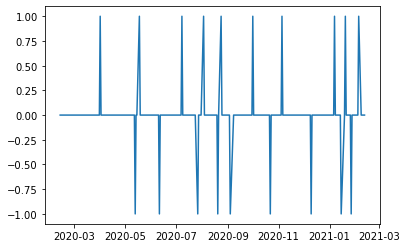

In [339]:
# Take a look at an example signal plot
plt.plot(df.MACD_Signal)

## Strategies
More info: https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html

### SMA Cross

In [239]:
class SmaCross(Strategy):
    # Define parameters of the strategy
    fast = 3
    slow = 15
    long_only = 1
    
    def init(self):
        # Compute moving averages
        self.fast_sma = self.I(SMA, self.data.Close, self.fast)
        self.slow_sma = self.I(SMA, self.data.Close, self.slow)
            
    def next(self):
        # If fast SMA crosses above slow SMA
        if crossover(self.fast_sma, self.slow_sma):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if fast SMA crosses below slow SMA
        elif crossover(self.slow_sma, self.fast_sma):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### MACD Signal

More info: https://www.investopedia.com/terms/m/macd.asp

In [332]:
class MacdSignal(Strategy): 
    # Define parameters of the strategy
    fastperiod = 12
    slowperiod = 26
    signalperiod = 9
    long_only = 1
    
    def init(self):
        # Compute MACD
        self.macd, self.macdsignal, self.macdhist = self.I(
             MACD, self.data.Close, self.fastperiod, self.slowperiod, self.signalperiod)
        
    def next(self):
        # If MACD crosses above signal line
        if crossover(self.macd, self.macdsignal):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if MACD crosses below signal line
        elif crossover(self.macdsignal, self.macd):
            self.position.close()
            if self.long_only == 0:
                self.sell()

### RSI
More info: https://www.investopedia.com/terms/r/rsi.asp

In [340]:
### NEED TO CONTINUE TO REFINE THIS ###

class RSISignal(Strategy): 
    # Define parameters of the strategy
    timeperiod = 14
    overbought = 70
    oversold = 30
    long_only = 0
    
    def init(self):
        # Compute RSI
        self.real = self.I(RSI, self.data.Close, self.timeperiod)
        
    def next(self):
        # If MACD crosses above signal line
        if crossover(oversold, self.real):
            if self.long_only == 0:
                self.position.close()
            self.buy()

        # Else, if MACD crosses below signal line
        elif crossover(self.real, overbought):
            self.position.close()
            if self.long_only == 0:
                self.sell()

## Backtesting Strategies
Additional info: https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html

In [337]:
# Specify data timeframe and strategy to test
# Get data from Yahoo
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,3y,5y,10y,ytd,max
# S&P500 index: ^GSPC
data = yf.download("SPY", period="1y")
strategy = MacdSignal

# Run backtesting
bt = Backtest(data, strategy, cash=10_000, commission=0)
stats = bt.run()

# Display stats and plot results
print(stats)
bt.plot()

[*********************100%***********************]  1 of 1 completed
Start                     2020-02-13 00:00:00
End                       2021-02-12 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                   46.245059
Equity Final [$]                 10997.499817
Equity Peak [$]                  11440.380066
Return [%]                           9.974998
Buy & Hold Return [%]               16.489651
Return (Ann.) [%]                    9.933675
Volatility (Ann.) [%]               12.384221
Sharpe Ratio                         0.802124
Sortino Ratio                        1.162584
Calmar Ratio                         1.199229
Max. Drawdown [%]                   -8.283385
Avg. Drawdown [%]                    -1.92895
Max. Drawdown Duration       86 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                    9
Win Rate [%]                        66.666667
Best Trade [%]                       4.290015
Worst Trade

In [27]:
# Contains individual trade data
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,35,20,29,281.369995,281.109985,-9.100342,-0.000924,2019-03-14,2019-03-27,13 days
1,35,31,32,282.390015,284.700012,80.849915,0.008180,2019-03-29,2019-04-01,3 days
2,35,33,58,286.040009,287.529999,52.149658,0.005209,2019-04-02,2019-05-08,36 days
3,35,79,94,285.929993,292.579987,232.749786,0.023257,2019-06-07,2019-06-28,21 days
4,34,95,109,296.679993,297.609985,31.619751,0.003135,2019-07-01,2019-07-22,21 days
5,34,112,118,300.940002,293.850006,-241.059875,-0.023560,2019-07-25,2019-08-02,8 days
6,34,131,135,292.480011,289.540009,-99.960083,-0.010052,2019-08-21,2019-08-27,6 days
7,34,138,155,294.220001,295.959991,59.159668,0.005914,2019-08-30,2019-09-25,26 days
8,34,169,205,297.100006,312.230011,514.420166,0.050926,2019-10-15,2019-12-05,51 days
9,33,207,241,314.440002,328.380005,460.020081,0.044333,2019-12-09,2020-01-29,51 days


In [28]:
# Contains equity/drawdown curves. DrawdownDuration is only defined at ends of DD periods.
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
2019-02-13,10000.000000,0.000000,NaT
2019-02-14,10000.000000,0.000000,NaT
2019-02-15,10000.000000,0.000000,NaT
2019-02-19,10000.000000,0.000000,NaT
2019-02-20,10000.000000,0.000000,NaT
...,...,...,...
2021-02-08,13831.767670,0.003681,NaT
2021-02-09,13822.667328,0.004337,NaT
2021-02-10,13816.716858,0.004766,NaT
2021-02-11,13838.767029,0.003177,NaT
